In [1]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.camera import CameraCalibration, Camera, CameraPose
from src.camera.video import VideoStream
from src.segmentation.circledetector import CircleDetector
from src.segmentation.yolo_detector import SplitYoloDetector
from src.segmentation.split_image import ImageSplitter, crop_image_xy
from src.pose.position_estimation import PositionEstimation
from src.pose.velocity_regression import velocity_regression
from src.ukf import BallUKF
from src.ukf.measurement import PixelPositionMeasurementMode
from src.pingpong.ball import BallConstants
from src.pingpong.table import TableConstants
from src.fileutils import DATA_DIR, MODELS_DIR
import src.visualization.plot3D as plot3D

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLOWorld
from scipy.spatial.transform import Rotation
from itertools import islice

In [3]:
# Define constants
CALIBRATION_VIDEO_PATH = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV'
VIDEO_PATH = DATA_DIR / "videos" / "IMG_5385.MOV"

BALL = BallConstants()
TABLE = TableConstants()

CAMERA_POSITION = np.array([0, -(TABLE.net_width + 2), 0.5])
CAMERA_ORIENTATION = Rotation.from_euler('xyz', [-90, 0, 0], degrees=True)
CAMERA_MIRROR_Y = False


In [4]:
# Get camera calibration
calibration_video = VideoStream(DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV')
print(calibration_video)
calibration = CameraCalibration.from_calibration_video(tqdm(calibration_video, total=calibration_video.get_length_if_known()))
calibration.intrinsic_matrix

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\calibration\Priyanshu_iPhone13.MOV
	FPS: 212.2765805331427
	Frames: 866
	Resolution: 1920x1080



100%|██████████| 866/866 [00:23<00:00, 36.23it/s]


array([[     1773.6,           0,      911.76],
       [          0,        2188,      544.32],
       [          0,           0,           1]])

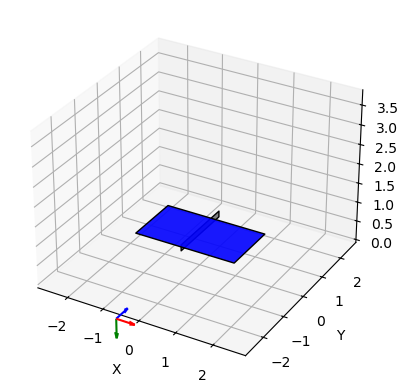

In [5]:
# Initialize camera
camera_pose = CameraPose(CAMERA_POSITION, CAMERA_ORIENTATION, mirror_y=CAMERA_MIRROR_Y)
camera = Camera(camera_pose, calibration)

# Plot the camera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot3D.plot_table(ax, TABLE)
plot3D.plot_camera(ax, camera)

In [6]:

# Initialize position estimator and circle detector
position_estimator = PositionEstimation(camera, BALL, TABLE)
circle_detector = CircleDetector()

test_pos = np.array([0, -3, 1])
test_pos_camera_frame = camera.pose.transform_to_camera_reference_frame(test_pos)
test_pos_image = position_estimator.project_ball_position_table_reference_frame_to_camera_plane(test_pos)

print("Camera position: ", camera.pose.position)
print("Camera orientation: ", camera.pose.orientation.as_euler('xyz', degrees=True))
print("Test position: ", test_pos)
print("Test position in camera frame: ", test_pos_camera_frame)
print("Test position in camera plane: ", test_pos_image)

Camera position:  [          0      -3.835         0.5]
Camera orientation:  [        -90           0           0]
Test position:  [ 0 -3  1]
Test position in camera frame:  [          0        -0.5       0.835]
Test position in camera plane:  (912, -766, 85)


In [7]:
# Load video 
video = VideoStream(VIDEO_PATH)
#dt = 1/ video.fps
dt = 1/220
video

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\videos\IMG_5385.MOV
	FPS: 26.625
	Frames: 213
	Resolution: 1920x1080

In [8]:
# Init yolo
model = YOLOWorld(str(MODELS_DIR / 'yolov8l-world.pt'))
model.conf = 0.01
model.iou = 0.1

# Split the frame into smaller overlapping regions
split_height = video.height // 4
split_width = video.width // 4
overlap = 0.2
splitter = ImageSplitter(split_height=split_height, split_width=split_width, overlap=overlap)

detector = SplitYoloDetector(model, splitter)


Bounding box [824, 779, 851, 805] detected with confidence 0.6423621773719788
Ball position table ref  [   -0.11501     -1.1064     0.19112] at time 0.0
Ball position camera ref [   -0.11501     0.30888      2.7286] at time 0.0


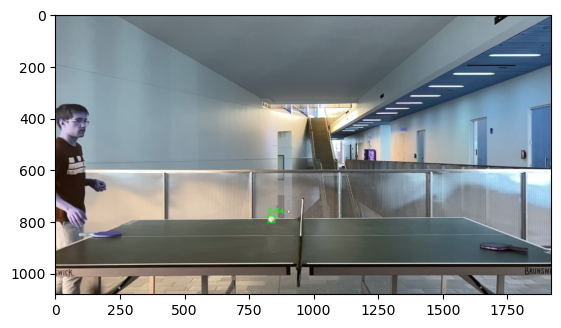

Bounding box [821, 774, 847, 800] detected with confidence 0.7269150614738464
Ball position table ref  [   -0.11962     -1.1064     0.19736] at time 0.004545454545454545
Ball position camera ref [   -0.11962     0.30264      2.7286] at time 0.004545454545454545


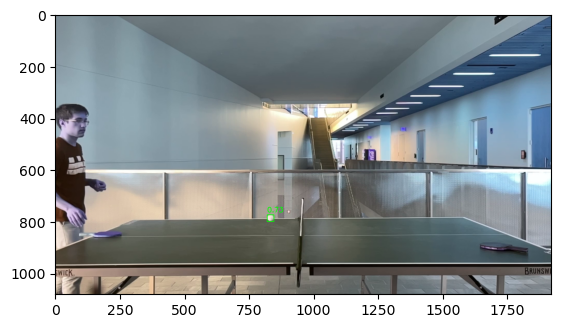

In [9]:
# Kalman Initialization Frames
n_initialization_frames = 2
initial_positions = []
initial_times = []
annotated_frames = []

for i, frame in enumerate(islice(video, n_initialization_frames)):

    box, conf = detector.detect(frame, yolo_verbose = False, debug_plots = False)
    annotated_frame = frame.copy()

    if box is not None:
        print(f"Bounding box {box} detected with confidence {conf}")
        detector.draw_bounding_box(annotated_frame, box, conf)

        center_x = (box[0] + box[2]) // 2
        center_y = (box[1] + box[3]) // 2
        diameter = min(box[2] - box[0], box[3] - box[1])

        # Get the ball position
        ball_position = position_estimator.ball_position_table_reference_frame(center_x, center_y, diameter)
        ball_position_cam = position_estimator.ball_position_camera_reference_frame(center_x, center_y, diameter)

        initial_positions.append(ball_position)
        initial_times.append(i * dt)
        print(f"Ball position table ref  {ball_position} at time {i * dt}")
        print(f"Ball position camera ref {ball_position_cam} at time {i * dt}")


    else:
        print("No ball detected")

    plt.figure()
    plt.imshow(annotated_frame)
    plt.show()

    annotated_frames.append(annotated_frame)        

In [10]:
# Linear regression over initial positions to get initial velocity
initial_positions = np.array(initial_positions)
initial_times = np.array(initial_times)
initial_velocity = velocity_regression(initial_times, initial_positions)
print(f"Initial velocity: {initial_velocity}")

# Keep track of the states
states = [
    np.array([*initial_positions[i], *initial_velocity, 0, 0, 0, 0, 0, 0]) for i in range(len(initial_positions))
]

Initial velocity: [    -1.0154 -2.4425e-14      1.3718]


In [11]:
# Initialize Kalman Filter

# Measurement noise is in units of pixels since we are using PixelPositionMeasurementMode
measurement_noise = np.eye(3) * 2
measurement_mode = PixelPositionMeasurementMode(measurement_noise, position_estimator)

initial_state = states[-1]
initial_covariance = np.eye(12) * 0.01

# Process noise should be relatively small
process_noise = np.eye(12) * 0.01

ukf = BallUKF(BALL, initial_state, initial_covariance, process_noise, measurement_mode)

Predicted State
 [   -0.11962     -1.1064     0.19736     -1.0154 -2.4455e-14      1.3718           0           0   -0.044591           0           0           0]
Mu of transformed region
 [        834         787          26]
Covariance of transformed region
 [[     8566.7     -66.667 -6.2909e-22]
 [    -66.667       13467  3.5075e-22]
 [-6.2879e-22  3.5096e-22  1.6281e-22]]
Lower Bound (1 STD) 
 [741 671  26]
Upper Bound (1 STD) 
 [927 903  26]
predicted_projection (834, 787, 26)
Bounding box [817, 770, 842, 795] detected with confidence 0.8031051754951477


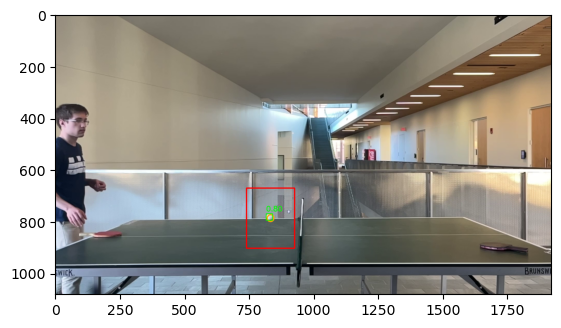

Predicted State
 [   -0.11962     -1.1064     0.19715     -1.0154  -2.441e-14      1.3718  2.6045e-20 -4.9446e-20   -0.089206           0           0           0]
Mu of transformed region
 [        834      803.67          26]
Covariance of transformed region
 [[      13367     -83.333  -6.279e-22]
 [    -83.333       19969  3.1832e-10]
 [-6.2809e-22  3.1832e-10  1.6281e-22]]
Lower Bound (1 STD) 
 [718 662  26]
Upper Bound (1 STD) 
 [950 945  26]
predicted_projection (834, 787, 26)
Bounding box [813, 765, 839, 788] detected with confidence 0.39700794219970703


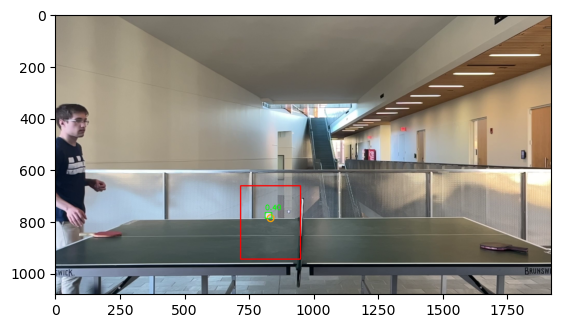

Predicted State
 [   -0.11962     -1.1064     0.19675     -1.0154 -2.4478e-14      1.3718 -2.8035e-18  9.5053e-17    -0.13384           0           0           0]
Mu of transformed region
 [        834      820.33          26]
Covariance of transformed region
 [[      17667     -116.67  -6.281e-22]
 [    -116.67       27844  6.3665e-10]
 [-6.2822e-22  6.3665e-10  1.6281e-22]]
Lower Bound (1 STD) 
 [701 653  26]
Upper Bound (1 STD) 
 [967 987  26]
predicted_projection (834, 787, 26)
Bounding box [809, 761, 834, 786] detected with confidence 0.3567380905151367


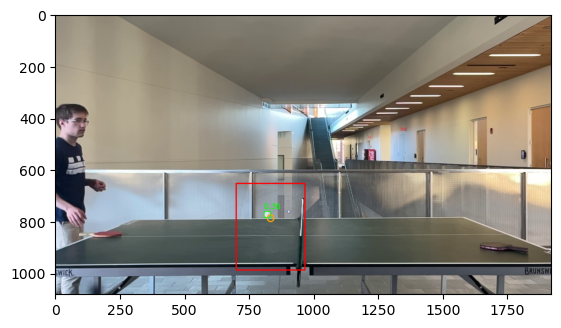

Predicted State
 [   -0.11962     -1.1064     0.19614     -1.0154 -2.4432e-14      1.3718  5.6386e-17   1.268e-16    -0.17849           0           0           0]
Mu of transformed region
 [        834         788          26]
Covariance of transformed region
 [[      20867        -100 -6.2781e-22]
 [       -100       32333 -1.6662e-21]
 [-6.2831e-22 -1.6663e-21  1.6281e-22]]
Lower Bound (1 STD) 
 [690 608  26]
Upper Bound (1 STD) 
 [978 968  26]
predicted_projection (834, 788, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


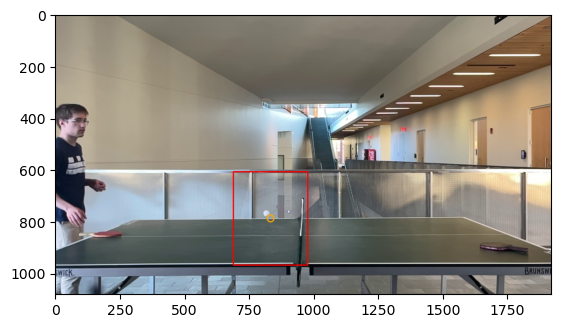

Predicted State
 [   -0.11962     -1.1064     0.19533     -1.0154 -2.4444e-14      1.3718  7.8649e-17 -3.1138e-17    -0.22316           0           0           0]
Mu of transformed region
 [        834      772.33          26]
Covariance of transformed region
 [[      26167     -116.67   -6.28e-22]
 [    -116.67       39503 -3.1832e-10]
 [-6.2803e-22 -3.1832e-10  1.6281e-22]]
Lower Bound (1 STD) 
 [672 574  26]
Upper Bound (1 STD) 
 [996 971  26]
predicted_projection (834, 789, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


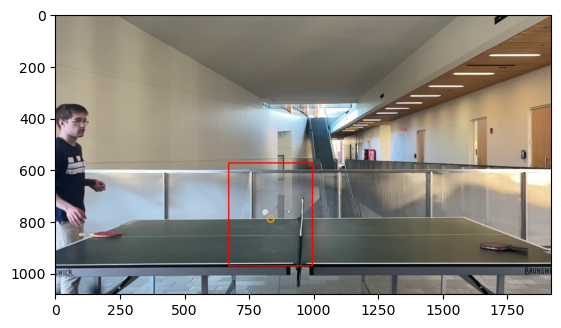

Predicted State
 [   -0.11962     -1.1064     0.19431     -1.0154 -3.9678e-14      1.3718 -1.4757e-17 -9.0716e-17    -0.26785           0           0           0]
Mu of transformed region
 [        834      822.33          26]
Covariance of transformed region
 [[      30033        -150 -1.3704e-21]
 [       -150       47311  6.3665e-10]
 [-1.3706e-21  6.3665e-10  1.6281e-22]]
Lower Bound (1 STD) 
 [661 605  26]
Upper Bound (1 STD) 
 [1007 1040   26]
predicted_projection (834, 789, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


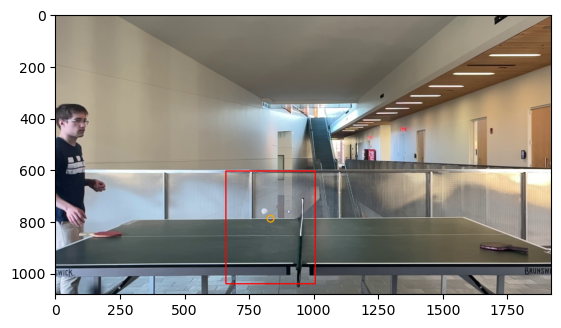

Predicted State
 [   -0.11962     -1.1064      0.1931     -1.0154 -6.2626e-14      1.3718  1.7958e-17 -8.7248e-17    -0.31257           0           0           0]
Mu of transformed region
 [        834      823.33          26]
Covariance of transformed region
 [[      34167        -150 -6.2785e-22]
 [       -150       54911  6.3665e-10]
 [-6.2857e-22  6.3665e-10  1.6281e-22]]
Lower Bound (1 STD) 
 [649 589  26]
Upper Bound (1 STD) 
 [1019 1058   26]
predicted_projection (834, 790, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


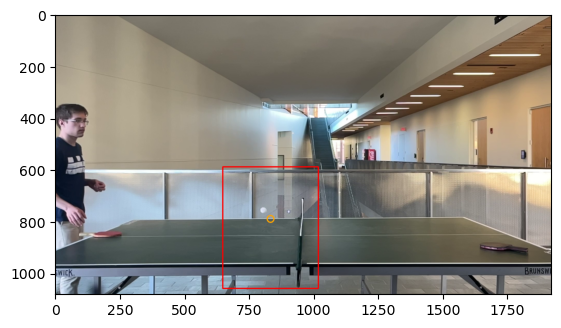

Predicted State
 [   -0.11962     -1.1064     0.19168     -1.0154 -6.2567e-14      1.3718  1.1094e-16 -3.2483e-16    -0.35731           0           0           0]
Mu of transformed region
 [     817.33      758.67      42.667]
Covariance of transformed region
 [[      39169      888.89     -586.11]
 [     888.89       60311     -1038.9]
 [    -586.11     -1038.9      569.44]]
Lower Bound (1 STD) 
 [619 513  19]
Upper Bound (1 STD) 
 [1015 1004   67]
predicted_projection (834, 792, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


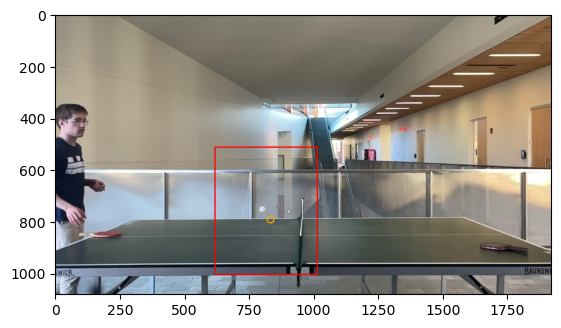

Predicted State
 [   -0.11962     -1.1064     0.19005     -1.0154 -5.4873e-14      1.3718  2.2638e-16 -3.0329e-16    -0.40209           0           0           0]
Mu of transformed region
 [        834         793          26]
Covariance of transformed region
 [[      43333     -333.33     -66.667]
 [    -333.33       65367      166.67]
 [    -66.667      166.67      33.333]]
Lower Bound (1 STD) 
 [626 537  20]
Upper Bound (1 STD) 
 [1042 1049   32]
predicted_projection (834, 793, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


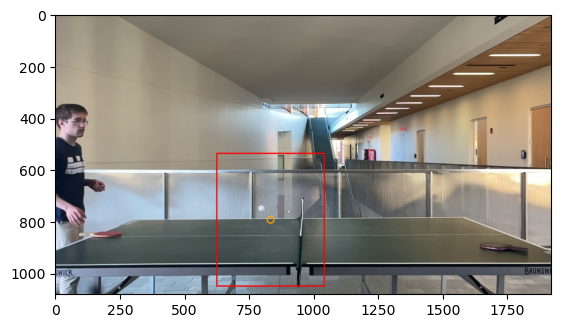

Predicted State
 [   -0.11962     -1.1064     0.18822     -1.0154 -2.3919e-14      1.3718  3.4346e-16 -2.5684e-16    -0.44689           0           0 -1.1686e-16]
Mu of transformed region
 [        834      810.67          26]
Covariance of transformed region
 [[      45767     -366.67     -66.667]
 [    -366.67       72103      183.33]
 [    -66.667      183.33      33.333]]
Lower Bound (1 STD) 
 [620 542  20]
Upper Bound (1 STD) 
 [1048 1079   32]
predicted_projection (834, 794, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


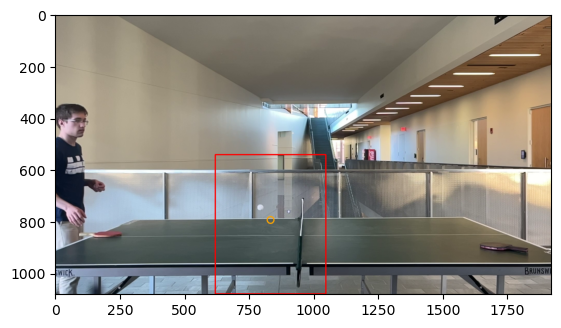

Predicted State
 [   -0.11962     -1.1064     0.18619     -1.0154 -2.3968e-14      1.3718  1.8359e-16 -1.9167e-16    -0.49174           0           0 -7.8713e-15]
Mu of transformed region
 [        834      812.67          26]
Covariance of transformed region
 [[      50833     -366.67     -66.667]
 [    -366.67       78369      183.33]
 [    -66.667      183.33      33.333]]
Lower Bound (1 STD) 
 [609 533  20]
Upper Bound (1 STD) 
 [1059 1093   32]
predicted_projection (834, 796, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


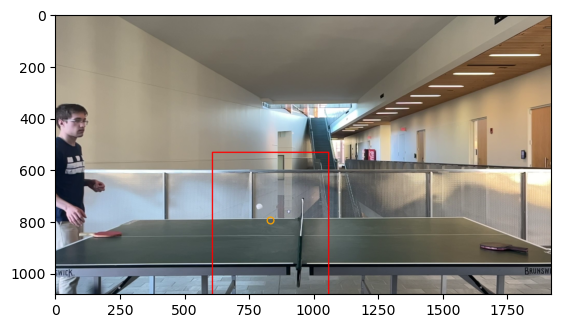

Predicted State
 [   -0.11962     -1.1064     0.18396     -1.0154 -1.5946e-14      1.3718   2.485e-16 -3.1268e-16    -0.53662           0           0  7.6769e-15]
Mu of transformed region
 [        834         798          26]
Covariance of transformed region
 [[      56167        -400     -66.667]
 [       -400       84533         200]
 [    -66.667         200      33.333]]
Lower Bound (1 STD) 
 [597 507  20]
Upper Bound (1 STD) 
 [1071 1089   32]
predicted_projection (834, 798, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


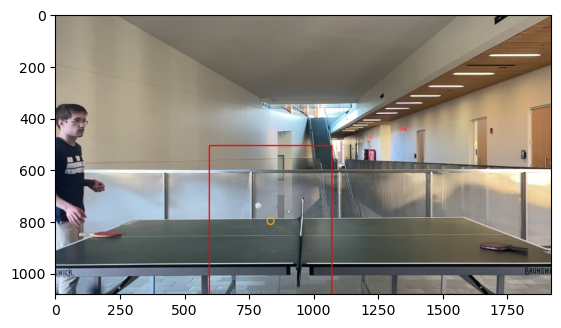

Predicted State
 [   -0.11962     -1.1064     0.18152     -1.0154 -8.0749e-15      1.3718  2.5768e-16 -2.3782e-16    -0.58154           0           0  1.5673e-14]
Mu of transformed region
 [        834         800          26]
Covariance of transformed region
 [[      58933        -400     -66.667]
 [       -400       91333         200]
 [    -66.667         200      33.333]]
Lower Bound (1 STD) 
 [591 498  20]
Upper Bound (1 STD) 
 [1077 1102   32]
predicted_projection (834, 800, 26)
Bounding box [768, 718, 788, 744] detected with confidence 0.2672712504863739


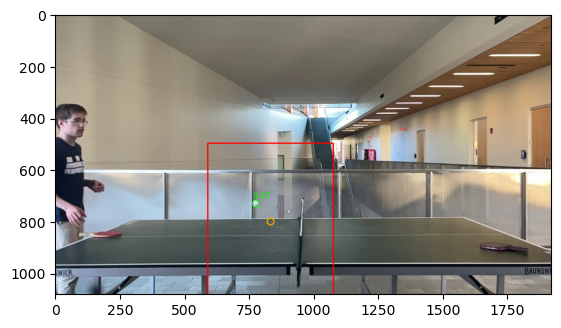

Predicted State
 [   -0.11962     -1.1064     0.17888     -1.0154 -7.8797e-15      1.3718  4.5979e-16 -7.2091e-17     -0.6265           0           0  3.1515e-14]
Mu of transformed region
 [        834         802          26]
Covariance of transformed region
 [[      64667        -400     -66.667]
 [       -400       98400         200]
 [    -66.667         200      33.333]]
Lower Bound (1 STD) 
 [580 488  20]
Upper Bound (1 STD) 
 [1088 1116   32]
predicted_projection (834, 802, 26)
Bounding box [759, 715, 785, 740] detected with confidence 0.343921422958374


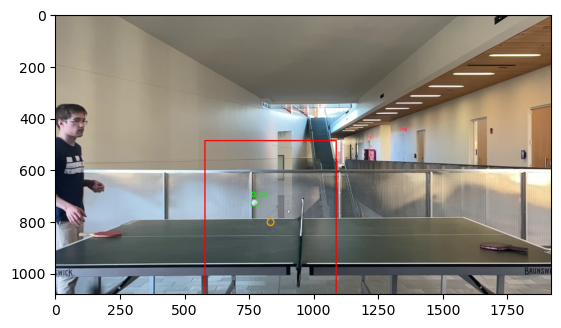

Predicted State
 [   -0.11962     -1.1064     0.17603     -1.0154  1.6085e-14      1.3718  4.3084e-16 -1.8597e-16     -0.6715           0           0  3.1925e-14]
Mu of transformed region
 [        834      837.33          26]
Covariance of transformed region
 [[      67633     -433.33     -66.667]
 [    -433.33  1.0631e+05      216.67]
 [    -66.667      216.67      33.333]]
Lower Bound (1 STD) 
 [574 511  20]
Upper Bound (1 STD) 
 [1094 1163   32]
predicted_projection (834, 804, 26)
Bounding box [755, 713, 781, 738] detected with confidence 0.26206061244010925


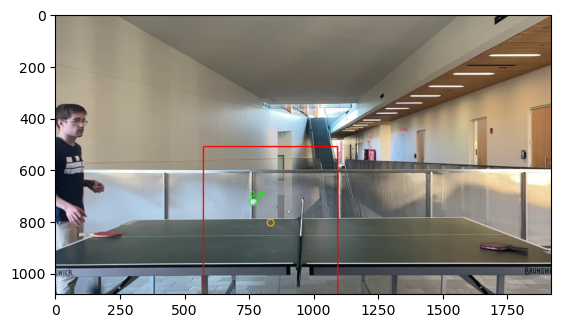

Predicted State
 [   -0.11962     -1.1064     0.17298     -1.0154  1.5931e-14      1.3718  3.9208e-16  1.5404e-16    -0.71656           0           0  3.1857e-14]
Mu of transformed region
 [        834      790.33          26]
Covariance of transformed region
 [[      70667     -466.67     -66.667]
 [    -466.67   1.124e+05      233.33]
 [    -66.667      233.33      33.333]]
Lower Bound (1 STD) 
 [568 455  20]
Upper Bound (1 STD) 
 [1100 1126   32]
predicted_projection (834, 807, 26)
Bounding box [751, 710, 777, 736] detected with confidence 0.5605307817459106


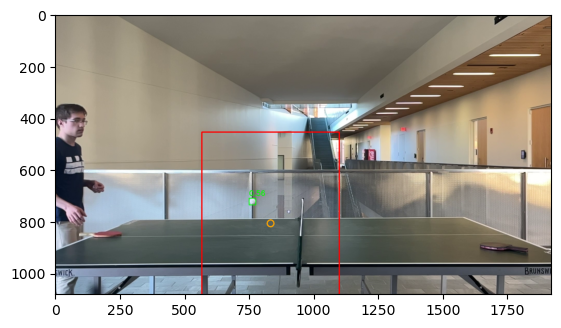

Predicted State
 [   -0.11962     -1.1064     0.16972     -1.0154  7.7668e-15      1.3718  4.7143e-16  6.0596e-16    -0.76166           0           0   1.553e-14]
Mu of transformed region
 [        834      825.67          26]
Covariance of transformed region
 [[      76933        -500     -66.667]
 [       -500  1.1847e+05         250]
 [    -66.667         250      33.333]]
Lower Bound (1 STD) 
 [557 481  20]
Upper Bound (1 STD) 
 [1111 1170   32]
predicted_projection (834, 809, 26)
Bounding box [747, 707, 773, 731] detected with confidence 0.3194492757320404


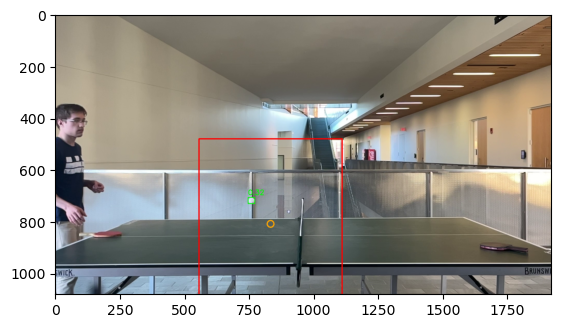

Predicted State
 [   -0.11962     -1.1064     0.16626     -1.0154  4.0431e-14      1.3718  3.8531e-16  7.8475e-16    -0.80682           0           0  1.5616e-14]
Mu of transformed region
 [        834      828.67          26]
Covariance of transformed region
 [[      80167        -500     -66.667]
 [       -500  1.2647e+05         250]
 [    -66.667         250      33.333]]
Lower Bound (1 STD) 
 [551 473  20]
Upper Bound (1 STD) 
 [1117 1184   32]
predicted_projection (834, 812, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


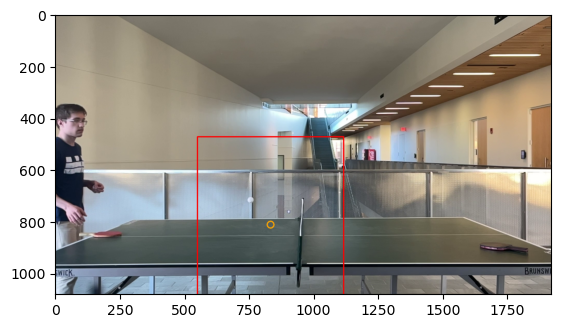

Predicted State
 [   -0.11962     -1.1064     0.16259     -1.0154  4.8428e-14      1.3718    4.63e-16  1.0586e-15    -0.85203           0           0  2.4043e-14]
Mu of transformed region
 [        834         815          26]
Covariance of transformed region
 [[      83467     -533.33     -66.667]
 [    -533.33  1.3027e+05      266.67]
 [    -66.667      266.67      33.333]]
Lower Bound (1 STD) 
 [545 454  20]
Upper Bound (1 STD) 
 [1123 1176   32]
predicted_projection (834, 815, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


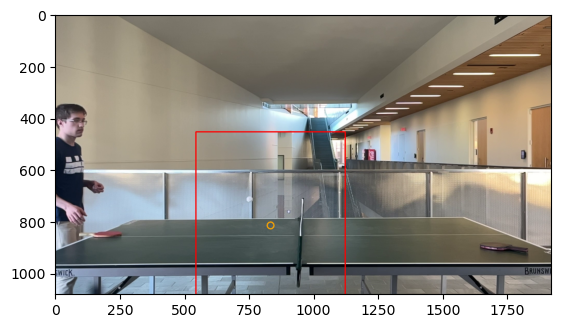

Predicted State
 [   -0.11962     -1.1064     0.15872     -1.0154  4.8452e-14      1.3718  3.3172e-16  7.5955e-16    -0.89729           0           0  3.2565e-14]
Mu of transformed region
 [        834         818          26]
Covariance of transformed region
 [[      90267     -533.33     -66.667]
 [    -533.33  1.3867e+05      266.67]
 [    -66.667      266.67      33.333]]
Lower Bound (1 STD) 
 [534 446  20]
Upper Bound (1 STD) 
 [1134 1190   32]
predicted_projection (834, 818, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


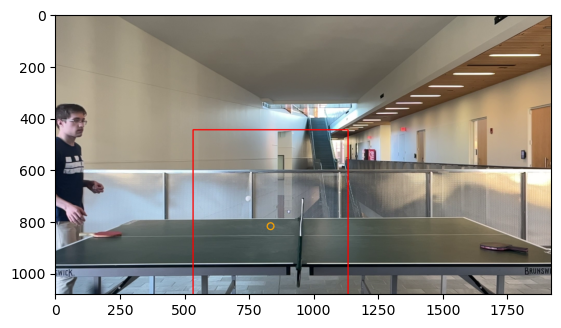

Predicted State
 [   -0.11962     -1.1064     0.15464     -1.0154  5.6915e-14      1.3718  4.4227e-16  8.4318e-16    -0.94262           0           0   3.225e-14]
Mu of transformed region
 [        834      854.33          26]
Covariance of transformed region
 [[      93767     -566.67     -66.667]
 [    -566.67  1.4764e+05      283.33]
 [    -66.667      283.33      33.333]]
Lower Bound (1 STD) 
 [528 470  20]
Upper Bound (1 STD) 
 [1140 1239   32]
predicted_projection (834, 821, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


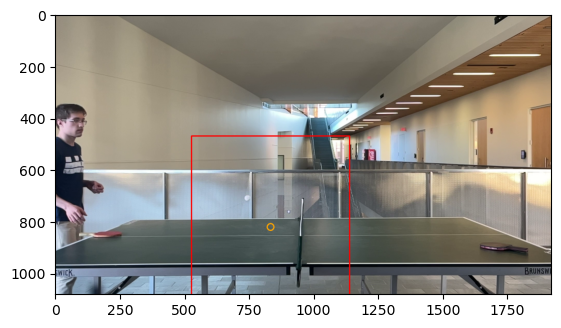

Predicted State
 [   -0.11962     -1.1064     0.15035     -1.0154  6.5557e-14      1.3718  3.6555e-16  1.1509e-15    -0.98801           0           0  1.5467e-14]
Mu of transformed region
 [        834      808.33          26]
Covariance of transformed region
 [[      97333        -600     -66.667]
 [       -600  1.5067e+05         300]
 [    -66.667         300      33.333]]
Lower Bound (1 STD) 
 [522 420  20]
Upper Bound (1 STD) 
 [1146 1196   32]
predicted_projection (834, 825, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


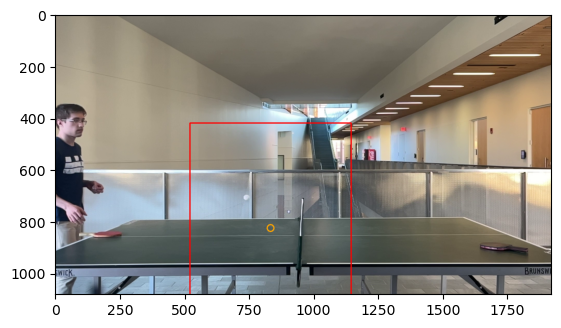

Predicted State
 [   -0.11962     -1.1064     0.14586     -1.0154  3.2212e-14      1.3718 -4.4925e-17  9.7449e-16     -1.0335           0           0  1.5555e-14]
Mu of transformed region
 [     817.33      844.67          26]
Covariance of transformed region
 [[  1.016e+05     -1269.4     -83.333]
 [    -1269.4   1.571e+05      283.33]
 [    -83.333      283.33      33.333]]
Lower Bound (1 STD) 
 [499 448  20]
Upper Bound (1 STD) 
 [1136 1241   32]
predicted_projection (834, 828, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


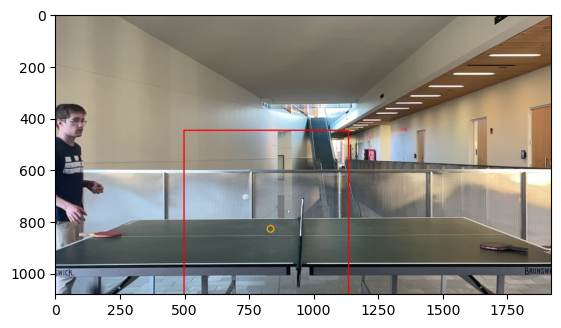

Predicted State
 [   -0.11962     -1.1064     0.14116     -1.0154  7.4051e-15      1.3718  2.2954e-16  8.0842e-16      -1.079           0           0  1.5643e-14]
Mu of transformed region
 [     817.33      848.67          26]
Covariance of transformed region
 [[  1.053e+05     -1352.8     -83.333]
 [    -1352.8   1.669e+05      316.67]
 [    -83.333      316.67      33.333]]
Lower Bound (1 STD) 
 [493 440  20]
Upper Bound (1 STD) 
 [1142 1257   32]
predicted_projection (834, 832, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


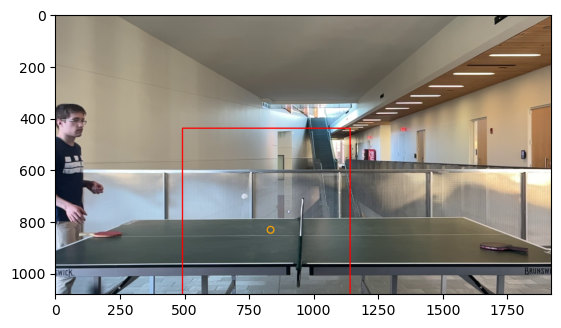

Predicted State
 [   -0.11962     -1.1064     0.13626     -1.0154 -9.4792e-15      1.3718  3.7214e-16  8.0718e-16     -1.1246           0           0  2.4106e-14]
Mu of transformed region
 [     817.33      852.67          26]
Covariance of transformed region
 [[  1.129e+05     -1352.8     -83.333]
 [    -1352.8   1.716e+05      316.67]
 [    -83.333      316.67      33.333]]
Lower Bound (1 STD) 
 [481 438  20]
Upper Bound (1 STD) 
 [1153 1267   32]
predicted_projection (834, 836, 26)
No ball detected by YOLO, trying circle detector
0 circles detected by Hough Circle Detector. Skipping update step.


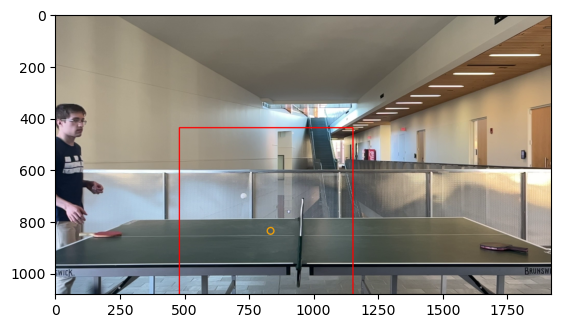

Predicted State
 [   -0.11962     -1.1064     0.13115     -1.0154 -3.4477e-14      1.3718  4.2553e-16  1.1202e-15     -1.1702           0           0  4.0832e-14]
Mu of transformed region
 [     817.33      856.67          26]
Covariance of transformed region
 [[  1.168e+05     -1352.8     -83.333]
 [    -1352.8  1.7637e+05      316.67]
 [    -83.333      316.67      33.333]]
Lower Bound (1 STD) 
 [476 437  20]
Upper Bound (1 STD) 
 [1159 1277   32]
predicted_projection (834, 840, 26)


In [12]:
for i, frame in enumerate(video):

    annotated_frame = frame.copy()

    # Get the high probability region in which we can find the ball    
    ukf.predict(dt)
    predicted_state = ukf.state
    lower, upper, mu, cov = ukf.get_high_likelihood_measurement_region(n_std_devs=1)
    lower, upper = np.round(lower, 0).astype(np.int64), np.round(upper, 0).astype(np.int64)

    print("Predicted State\n", predicted_state)
    print("Mu of transformed region\n", mu)
    print("Covariance of transformed region\n", cov)
    print("Lower Bound (1 STD) \n", lower)
    print("Upper Bound (1 STD) \n", upper)

    # Draw the ball's predicted position in orange
    predicted_projection = position_estimator.project_ball_position_table_reference_frame_to_camera_plane(predicted_state[:3])
    annotated_frame = cv2.circle(annotated_frame, (int(predicted_projection[0]), int(predicted_projection[1])), predicted_projection[2]//2, (0, 165, 255), 4)

    print("predicted_projection", predicted_projection)

    # Draw the likely region in red
    annotated_frame = cv2.rectangle(annotated_frame, lower[:2], upper[:2], (0, 0, 255), 4)

    box, conf = detector.detect_in_subregion(frame, lower[0], lower[0], upper[0], upper[1], yolo_verbose = False, debug_plots = False)
    ball_detected = False

    if box is not None:
        ball_detected = True
        print(f"Bounding box {box} detected with confidence {conf}")
        detector.draw_bounding_box(annotated_frame, box, conf)

        center_x = (box[0] + box[2]) // 2
        center_y = (box[1] + box[3]) // 2
        diameter = min(box[2] - box[0], box[3] - box[1])

    else:
        print("No ball detected by YOLO, trying circle detector")
        circles = circle_detector.hough_circles(frame, minRadius=lower[2], maxRadius=upper[2], minDist=lower[2]//2, param1=50, param2=30)
        circles = circle_detector.filter_to_region(circles, lower, upper)
        sensitivity = 15
        lower_white = np.array([0,0,255-sensitivity])
        upper_white = np.array([255,sensitivity,255])
        if (len(circles) > 1):
            circles = circle_detector.filter_circles_by_color_threshold(frame, circles, lower_white, upper_white, threshold = 0.5)
        circle_detector.draw_circles(annotated_frame, circles, color=(0, 255, 0), thickness=2)
        if len(circles) == 1:
            ball_detected = True
            center_x, center_y, diameter = circles[0]
        else:
            print(f"{len(circles)} circles detected by Hough Circle Detector. Skipping update step.")

    
    plt.figure()
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.show()

    states.append(ukf.state)
    annotated_frames.append(annotated_frame)


In [ ]:
print(ukf.state)
print(ukf.state_covariance)

# Check symmetric positive definite
print(np.min(np.linalg.eigvals(ukf.state_covariance)))


In [ ]:
# Save the annotated images as a video
output_path = DATA_DIR / "output" / "annotated_ukf.mp4"
writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height))
for image in annotated_images:
    writer.write(image)
writer.release()